In [1]:
import astropy
from astropy.io import fits 
from astropy.time import Time
from astropy.visualization import time_support
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy.signal as sig
from astropy.stats import sigma_clip

In [2]:
from functools import partial

import matplotlib as mpl
from scipy import signal, stats
from scipy.ndimage import center_of_mass

# install moonbow first. in repo root:
# pip install -e . --no-deps
from moonbow.fit import Fit

rng = np.random.default_rng()

In [3]:
def dataClean(filename,distance_pc,eff_width): 
    
    """ This function removes nan values and corrects time values for TESS 20 second cadence data. 
        Also corrects TESS flux to energy in ergs."""
    
    #Create an array of time and flux data with nans removed    
    with fits.open(filename, mode="readonly") as hdulist:
        raw_time = hdulist[1].data['TIME']
        raw_flux = hdulist[1].data['PDCSAP_FLUX']
        raw_err = hdulist[1].data['PDCSAP_FLUX_ERR']
    data = np.vstack((raw_time, raw_flux, raw_err))
    nonan_data = data[:, ~np.isnan(data).any(axis=0)]

    times = nonan_data[0]
    flux = nonan_data[1]
    error = nonan_data[2]
    
    #Create Dataframe of cleaned data
    time = np.array(times)
    flux = np.array(flux)
    err = np.array(error)
   

    #Convert energy to ergs
    dist_cm = distance_pc * 3.086e+18
    ergs = []
    ergs_err = []
    
    for i in flux: 
        fluence = i * eff_width
        energy = (4 * np.pi * (dist_cm**2) * fluence)
        ergs.append(energy*1.95829e-9) #AB system zero point
        
    for i in err:
        fluence_err = i*eff_width
        energy_err = (4 * np.pi * (dist_cm**2) * fluence_err)
        ergs_err.append(energy_err*1.95829e-9) #AB system zero point
        
    energy = np.asarray(ergs)
    error = np.asarray(ergs_err)

    
    #Return cleaned data
    return pd.DataFrame({
                        'Time': time,
                        'Energy': energy,
                        'Energy Error': error,
                        'TESS Flux': flux
    })

In [4]:
#Using only until large flare function is completed, need more stars to get a better idea for a good
#model for stellar quiescence generation

def generate_Qcurve(clean_dataframe):
    """ This function takes cleaned data to create a dataframe of the estimated quiescent light curve"""

    q_time = clean_dataframe['Time'] # time associated w/ quiescent flux
    
    #Set and index variables
    fluxes = clean_dataframe['Energy']
    times = clean_dataframe['Time']
    F_err = clean_dataframe['Energy Error'] 

    #Smooth
    smooth_1 = sig.savgol_filter(fluxes,1400,3)
    q_flux = sig.savgol_filter(smooth_1,2000,3)
    
    #Create/return dataframe
    
    return pd.DataFrame({
                'Time': q_time,
                'Quiescent Energy':q_flux
    })


In [5]:
def find_ix_ranges(ix, buffer=False):
    """ Finds indexes in the range.
    
        From MC GALEX function defs"""
    
    foo, bar = [], []
    for n, i in enumerate(ix):
        if len(bar) == 0 or bar[-1] == i-1:
            bar += [i]
        else:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
            bar = [i]
        if n == len(ix)-1:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
    return foo

In [6]:
def get_inff(curve,distance_pc, clipsigma=3, quiet=True, band='NUV',
             binsize=20.):
    """ Calculates the Instantaneous Non-Flare Flux values.
    
        From MC GALEX function defs"""
    
    sclip = sigma_clip(np.array(curve['TESS Flux']), sigma_lower=clipsigma, sigma_upper=clipsigma)
    inff = np.median(sclip)
    inff_err = np.sqrt(inff*len(sclip)*binsize)/(len(sclip)*binsize)
    if inff and not quiet:
        print('Quiescent at {m} AB mag.'.format(m=gt.counts2mag(inff, band)))
    inff_ = ((inff*(3.898e-5))*(4*np.pi*((distance_pc*3.086e+18)**2)))*1.95829e-9
    inff_er = ((inff_err*(3.898e-5))*(4*np.pi*((distance_pc*3.086e+18)**2)))*1.95829e-9
    return inff, inff_er

In [49]:
def find_flare_ranges(curve,q_curve,sig,quiescence=None):
    """This function will run through the data to find 
    flares and ranges of flares. This function will return
    a table of flares ranges. 
    
    Adapted from MC GALEX function defs.
    Stage: complete"""
    
    tranges = [[min(curve['Time']), max(curve['Time'])]] 
    if not quiescence:
        q, q_err = get_inff(curve,35)
    else:
        q, q_err = quiescence
    flare_ranges = []
    for trange in tranges:
        ix = np.where(((np.array(curve['Energy'].values)-(sig*np.array(curve['Energy Error'].values)) >= q_curve['Quiescent Energy'])))[0]
        flareFlux = ix
        if not len(ix):
            continue
        flux_ix = []
        
        for ix_range in find_ix_ranges(ix):
            # go backwards
            consec = 0 
            err = curve.iloc[ix_range[0]]['Energy Error'] 
            #while flux - err > quiescence, find 2 consecutive points within quiescent curve
            while all(curve.iloc[ix_range[0]]['Energy']-err >= q_curve['Quiescent Energy']) and ix_range[0] > 0 or (consec < 1 and ix_range[0] >0):
                err = curve.iloc[ix_range[0]]['Energy Error']
                
                if all(curve.iloc[ix_range[0]]['Energy']- err < q_curve['Quiescent Energy']) :
                    consec +=1
                else: 
                    consec = 0
                if ((curve.iloc[ix_range[0]+1]['Time']-curve.iloc[ix_range[0]]['Time']) > 10):  #or (n_times > ??)
                    break               
                ix_range = [ix_range[0] - 1] + ix_range
                
                # go forwards
            consec = 0 
            n_times = 0
            err = curve.iloc[ix_range[-1]]['Energy Error']
            while all(curve.iloc[ix_range[-1]]['Energy']-err >= q_curve['Quiescent Energy']) and ix_range[-1] != len(curve)-1 or (consec <1 and ix_range[:-1]!= len(curve)-1):
                err = curve.iloc[ix_range[-1]]['Energy Error']
                if all(curve.iloc[ix_range[-1]]['Energy']-err < q_curve['Quiescent Energy']):
                    consec += 1
                else: 
                    consec = 0
                if ((curve.iloc[ix_range[-1]+1]['Time']-curve.iloc[ix_range[-1]]['Time']) > 10):  #or (n_times > ??)
                    break
                ix_range = ix_range + [ix_range[-1] + 1]
                
            flux_ix += ix_range
        ix = np.unique(flux_ix)
        flare_ranges += find_ix_ranges(list(np.array(ix).flatten()))
    return(flare_ranges,flareFlux)

In [37]:
def refine_flare_ranges(curve,q_curve, sig=3., flare_ranges=None):
    """ Identify the start and stop indexes of a flare event after
    refining the INFF by masking out the initial flare detection indexes. 
    From MC GALEX function defs."""
    time_support()
    if not flare_ranges:
        flare_ranges, _ = find_flare_ranges(curve, q_curve, sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    quiescience_mask = [False if i in flare_ix else True for i in
                        np.arange(len(curve['Time']))]
    quiescence = q_curve
    quiescence_err = (np.sqrt(curve['Energy'][quiescience_mask].sum())/curve['Energy'].sum())
    flare_ranges, flare_3sigs = find_flare_ranges(curve,q_curve,
                                                  quiescence=(quiescence,
                                                              quiescence_err),
                                                  sig=sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    not_flare_ix = list(set([x for x in range(len(curve['Time']))]) - set(flare_ix))
      
    return flare_ranges, flare_ix

In [50]:
rawdata = '/Users/katborski/Documents/GitHub/AFPSC/TESS/tess2021232031932-s0042-0000000250081915-0213-a_fast-lc.fits'
flaring_frame = dataClean(rawdata,35,3.898e-5) #35=dist in pc, 3.898e-5=eff width for Af Psc
q_frame = generate_Qcurve(flaring_frame)

In [51]:
ranges_ix,energy_ix = find_flare_ranges(flaring_frame,q_frame,3)

/Users/katborski/opt/anaconda3/envs/moonbow/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [52]:
#flare_energies = tess_flux[energy_ix]
ranges = []
for i,v in enumerate(ranges_ix):
    t = flaring_frame['Time'][v]
    f = flaring_frame['Energy'][v]
    ranges.append([i,t,f])


In [53]:
#ranges 
# each element has 3 pieces, [0]=flare ID, [1]=times, [2]=energies



for i in range(len(ranges)):
    energies = ranges[i][2]
    norm = energies/max(energies)
    ax.flat[i].plot(norm)
    plt.setp(ax, xticks=[], yticks=[])
    plt.show()

In [54]:
#Select Large Flares

large_flares = []
for i,v in enumerate(ranges_ix):
    if len(v)>=80:                    #~26 minute minimum                    
        large_flares.append((v))
    else:
        continue

#Match Data to Large Flares

large_flare_data = []
for i,v in enumerate(large_flares):
    data = flaring_frame['Energy'][large_flares[i]]
    large_flare_data.append(data)
    
norm_flares=[] #normalize flare values
for i in range(len(large_flare_data)):
    mx = max(large_flare_data[i])
    norm_flares.append(large_flare_data[i]/mx)
    
times=[]
for i in range(len(large_flares)):
    t = flaring_frame['Time'][large_flare_data[i].index]
    times.append(t)

fig,ax = plt.subplots(2,4)
fig.set_size_inches(25,20)
fig.tight_layout()
for i in range(len(large_flare_data)):
    ax.flat[i].plot(norm_flares[i])
    plt.show()

In [55]:
def aflare2(t, tpeak, fwhm, ampl,
            c0,c1,c2,c3,c4,
            d0,d1,d2,d3):
#    t : 1-d array
#        The time array to evaluate the flare over
#    tpeak : float
#        The time of the flare peak
#    fwhm : float
#        The "Full Width at Half Maximum", timescale of the flare
#   ampl : float
#        The amplitude of the flare
#    Returns
#    flare : 1-d array
#        The flux of the flare model evaluated at each time
    #_fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fr = [c0,c1,c2,c3,c4]
    #_fd = [0.689008, -1.60053, 0.302963, -0.278318]
    _fd = [d0,d1,d2,d3]
    
    t = np.array(t)
    flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                (t > tpeak)],
                            [lambda x: (_fr[0]+                       # 0th order
                                        _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                        _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                        _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                        _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                             lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                        _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                            ) * np.abs(ampl) # amplitude

    return flare

/Users/katborski/opt/anaconda3/envs/moonbow/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


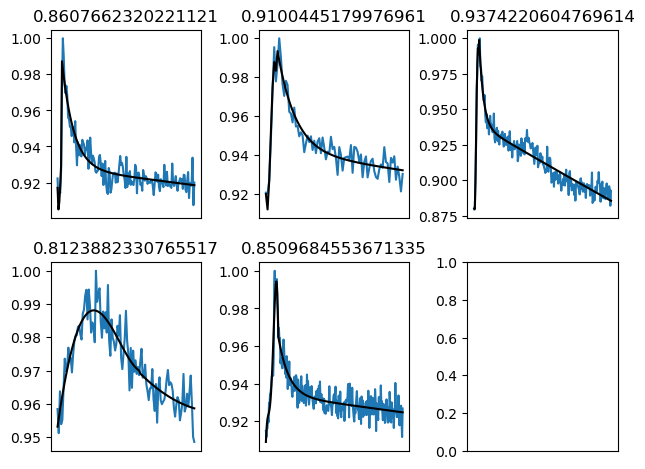

In [56]:
lg_flare_data=[]
lg_flare_time=[]
lg_flare_det=[]
lg_flare_params = []
fits_ = []

#figure out how to set # of subplots to # of large flares

fig, ax = plt.subplots(2,3)
fig.tight_layout()  
for i in range(len(large_flares)):
    model = aflare2
    x = flaring_frame['Time'][large_flares[i]]
    y = norm_flares[i]
    data = pd.DataFrame({'time': x, 'energy': y})
    
    rise = x[0:np.argmax(y)].values
    fwhm = (max(rise)-min(rise))*2
    
    fitter = Fit(
    underlying_function=model,
    dimensionality=1,
    data=data,
    dependent_variable='energy')
    
    fitter.make_vector(independent_variables=['time'])
    fitter.fit(guess=np.array((max(rise),fwhm,1,
                          1.00000, 1.94053, -0.175084, -2.24588, -1.12498,
                          0.689008, -1.60053, 0.302959, -0.278316))) 
    if fitter.det > 0.70:
        lg_flare_time.append(x)
        lg_flare_data.append(y)
        lg_flare_det.append(fitter.det)
        fit_params, covariance_matrix = fitter.curve_fit
        lg_flare_params.append((fit_params))
        fit = fitter.fitted_curve 
        fits_.append((fit))
    
for i in range(len(lg_flare_data)):    
    ax.flat[i].plot(lg_flare_time[i],lg_flare_data[i])
    ax.flat[i].plot(lg_flare_time[i],fits_[i],c='black')
    ax.flat[i].set_title(lg_flare_det[i])
    plt.setp(ax, xticks=[]) 
            #refit with fit_params??


In [57]:
len(lg_flare_data)

5

In [58]:
lg_flare_params

[array([ 2.44876780e+03,  4.84755897e-03,  1.45074731e+00,  6.53937140e-01,
         4.20467014e-01,  3.65107051e+00,  2.16885883e+01,  5.12633405e+01,
         4.10296277e-02, -1.59232050e+00,  6.39636747e-01, -1.42299702e-03]),
 array([ 2.45231607e+03,  4.24734922e-03,  1.28305181e+00,  7.47082884e-01,
        -5.36209031e-01, -3.26018558e+00, -1.39551024e+00,  7.70818425e+00,
         4.03714405e-02, -1.71544228e+00,  7.34057196e-01, -2.50917296e-03]),
 array([ 2.46134845e+03,  5.76767150e-03,  1.35015645e+00,  7.21402211e-01,
        -4.55759644e-01, -3.47706018e+00,  3.25583907e+00,  2.37171000e+01,
         4.52882700e-02, -3.66329217e+00,  6.95391474e-01, -6.76717049e-03]),
 array([ 2.46233314e+03,  8.46834949e-02,  6.68855090e-01,  1.45002284e+00,
        -1.07085424e-01,  5.92239184e+00,  4.78527412e+01,  5.04199459e+01,
         9.41307033e-01,  5.15648054e-01,  5.07749870e-01, -1.34482278e+00]),
 array([ 2.46807197e+03,  1.35580330e-02,  1.37884147e+00,  7.06998386e-01,
    

###TEST with EV Lac

In [59]:
test_rawdata = '/Users/katborski/Documents/GitHub/QPPs/moonbow-main/tess2022244194134-s0056-0000000154101678-0243-a_fast-lc.fits'
test_flaring_frame = dataClean(test_rawdata,5.05,3.898e-5) #5.05=dist in pc to EV Lac, 3.898e-5=eff width for TESS
test_q_frame = generate_Qcurve(test_flaring_frame)


In [ ]:
test_ranges_ix,test_energy_ix = find_flare_ranges(test_flaring_frame,test_q_frame,3)

/Users/katborski/opt/anaconda3/envs/moonbow/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [200]:
#flare_energies = tess_flux[energy_ix]
test_ranges = []
for i,v in enumerate(test_ranges_ix):
    t = test_flaring_frame['Time'][v]
    f = test_flaring_frame['Energy'][v]
    test_ranges.append([i,t,f])


In [201]:
peaks = []
ptimes = []
flares = []
for i in range(len(test_ranges)):
    if len(test_ranges[i][1]) < 10:
        continue
    else:
        mx = max(test_ranges[i][2].values)
        t_ix = np.argmax(test_ranges[i][2].values)
        t = min(test_ranges[i][1].index) -1
        p_t = test_ranges[i][1][(t+t_ix)]
        peaks.append(mx)
        ptimes.append(p_t)
        flares.append([test_ranges[i][1],test_ranges[i][2]])

In [202]:
len(flares)

142

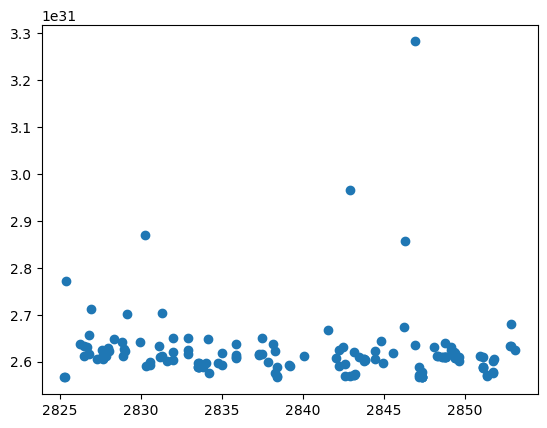

In [203]:
plt.scatter(ptimes,peaks)

In [204]:
len(test_ranges[1][2])

9

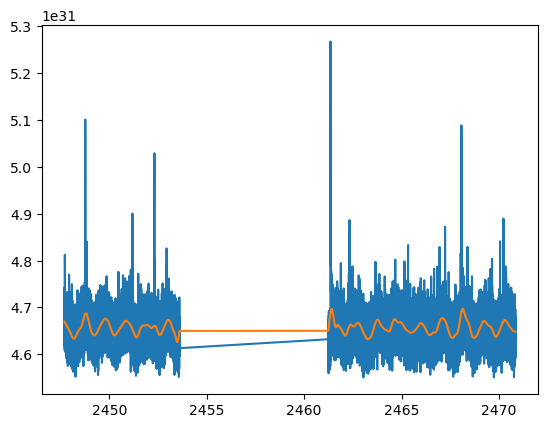

In [205]:
plt.plot(flaring_frame['Time'],flaring_frame['Energy'])
plt.plot(q_frame['Time'],q_frame['Quiescent Energy'])

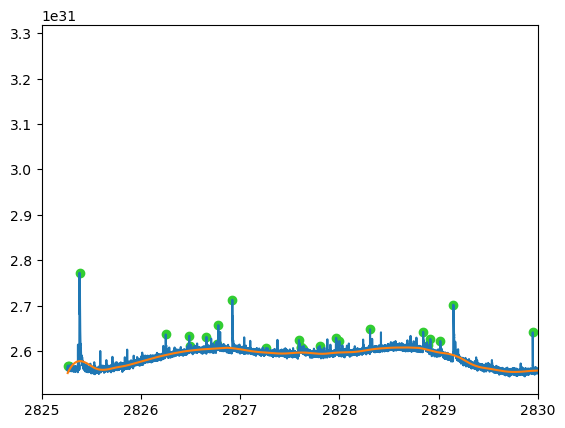

In [206]:
plt.xlim(2825,2830)
plt.plot(test_flaring_frame['Time'],test_flaring_frame['Energy'])
plt.plot(test_q_frame['Time'],test_q_frame['Quiescent Energy'])
plt.scatter(ptimes,peaks,color='limegreen')

In [ ]:
ix = np.where(np.isnan(test_flaring_frame['Time']))


In [ ]:
ix

In [23]:
test =  fits.open(test_rawdata)

In [34]:
test[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

In [ ]:
curve.iloc[ix_range[0]+1]['Time']-curve.iloc[ix_range[0]]['Time']) > 1000